># Artistic Neural Style Transfer

* Neural style transfer is an optimization technique used to take three images, a content image, a style reference image (such as an artwork by a famous painter), and the input image you want to style — and blend them together such that the input image is transformed to look like the content image, but “painted” in the style of the style image.


* For example:

![](http://www.renom.jp/notebooks/tutorial/image_processing/neural-style-transfer/fig/gatys2016_examples.png)



# Introduction

* Style transfer is a fun and interesting technique that showcases the capabilities and internal representations of neural networks.

* The principle of neural style transfer is to define two distance functions, one that describes how different the content of two images are , $L_{content}$, and one that describes the difference between two images in terms of their style, $L_{style}$. Then, given three images, a desired style image, a desired content image, and the input image (initialized with the content image), we try to transform the input image to minimize the content distance with the content image and its style distance with the style image. In summary, we’ll take the base input image, a content image that we want to match, and the style image that we want to match. We’ll transform the base input image by minimizing the content and style distances (losses) with backpropagation, creating an image that matches the content of the content image and the style of the style image.

# How does it work?

* We take input image and style images and resize them to equal shapes.
* We load a pre-trained Convolutional Neural Network (VGG16).
* Knowing that we can distinguish layers that are responsible for the style (basic shapes, colors etc.) and the ones responsible for the content (image-specific features), we can separate the layers to independently work on the content and style.
* Then we set our task as an optimization problem where we are going to minimize:
      * content loss (distance between the input and output images - we strive to preserve the content)
      * style loss (distance between the style and output images - we strive to apply a new style)
      * total variation loss (regularization - spatial smoothness to denoise the output image)
* Finally, we set our gradients and optimize with the L-BFGS algorithm.


In [1]:
# Importing the libraries:

import numpy as np
from PIL import Image

# Keras libraries
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions
from keras import backend
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

Using TensorFlow backend.


# Convolutional Neural Network:

>## "A single neuron in the brain is an incredibly complex machine that even today we don't understand. A single 'neuron' in a neural network is an incredibly simple mathematical function that captures a minuscule fraction of the complexity of a biological neuron." 
-Andrew Ng        

* Convolutional Neural Networks have proven to be very successful in the areas of image recognition, object detection, semantic segmentation. They have been very successfully used to enhance the capabilities of self-driving cars. They are also used in medical diagnosis to detect cancer tumours etc.

* Here is an example of CNN hierarchy from VGG net where shallow layers learns low level features and as we go deeper into the network these convolutional layers are able to represent much larger scale features and thus have a higher-level representation of the image content.


![Feature Visualization of the VGG Network](https://blog.keras.io/img/vgg16_filters_overview.jpg)

                                    Feature Visualization of the VGG Network 

# Define content and style representations
In order to get both the content and style representations of our image, we will look at some intermediate layers within our model. As we go deeper into the model, these intermediate layers represent higher and higher order features. In this case, we are using the network architecture VGG19, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from our images. For an input image, we will try to match the corresponding style and content target representations at these intermediate layers.
# Why intermediate layers?
You may be wondering why these intermediate outputs within our pretrained image classification network allow us to define style and content representations. At a high level, this phenomenon can be explained by the fact that in order for a network to perform image classification (which our network has been trained to do), it must understand the image. This involves taking the raw image as input pixels and building an internal representation through transformations that turn the raw image pixels into a complex understanding of the features present within the image. This is also partly why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g., cats vs. dogs) that are agnostic to background noise and other nuisances. Thus, somewhere between where the raw image is fed in and the classification label is output, the model serves as a complex feature extractor; hence by accessing intermediate layers, we’re able to describe the content and style of input images.




> # VGG Model

![](https://neurohive.io/wp-content/uploads/2018/11/vgg16.png)


* VGG-19 — It consists of 16 layers of convolution and ReLU non-linearity, separated by 5 pooling layers and ending in 3 fully connected layers.

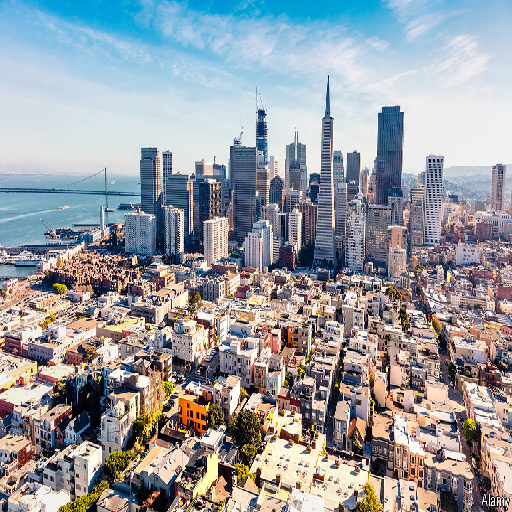

In [3]:
# Loading the content image:

content_image = Image.open('../input/images2/content.jpg')
content_image = content_image.resize((512, 512))
content_image

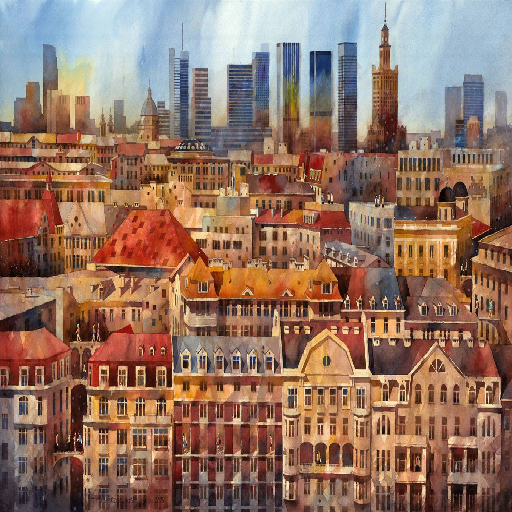

In [4]:
# Loading the styling image: 

style_image = Image.open('../input/images2/style.jpg')
style_image = style_image.resize((512, 512))
style_image

In [5]:
# Convertng the content image into an array:

content_array = np.asarray(content_image, dtype = 'float32')
content_array = np.expand_dims(content_array, axis = 0)
print("The shape of the content image array is:", content_array.shape)

The shape of the content image array is: (1, 512, 512, 3)


In [6]:
# Converting the styling array into an array:

style_array = np.asarray(style_image, dtype = 'float32')
style_array = np.expand_dims(style_array, axis=0)
print("The shape of the styling image array is:", style_array.shape)

The shape of the styling image array is: (1, 512, 512, 3)


> # Prepare the data

* We preprocess our images. We perform the same preprocessing process as are expected according to the VGG training process. VGG networks are trained on image with each channel normalized by mean = [103.939, 116.779, 123.68] and with channels BGR.

In [7]:
# Preprocessing the content array:

content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]
content_array.shape

(1, 512, 512, 3)

In [8]:
# Preprocessing the styling array:

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]
style_array.shape

(1, 512, 512, 3)

In [9]:
# Creating a placeholder for the three image variable:

# Defining the height and width of the images:
height = 512
width = 512

# Creating a placeholder for the content image:
content_image = backend.variable(content_array)

# Creating a placeholder for the styling image:
style_image = backend.variable(style_array)

# Creating a placeholder for the combined image:
combination_image = backend.placeholder((1,height,width,3))



In [10]:
# Concatenating the content and style image to feed it to the VGG network:

input_tensor=backend.concatenate([content_image,style_image,combination_image],axis=0)

In [11]:
# Loading the model:

model=VGG16(input_tensor = input_tensor, weights = 'imagenet', include_top = False)

58892288/58889256 [==============================] - 34s 1us/step


# Content representation and loss:

We can construct images whose feature maps at a chosen convolution layer match the corresponding feature maps of a given content image. We expect the two images to contain the same content — but not necessarily the same texture and style.
Given a chosen content layer l, the content loss is defined as the Mean Squared Error between the feature map F of our content image C and the feature map P of our generated image Y.

$$L^l_{content}(p, x) = \sum_{i, j} (F^l_{ij}(x) - P^l_{ij}(p))^2$$

When this content-loss is minimized, it means that the mixed-image has feature activation in the given layers that are very similar to the activation of the content-image. Depending on which layers we select, this should transfer the contours from the content-image to the mixed-image.

# Style representation and loss:
We will do something similar for the style-layers, but now we want to measure which features in the style-layers activate simultaneously for the style-image, and then copy this activation-pattern to the mixed-image.
One way of doing this, is to calculate the Gram-matrix(a matrix comprising of correlated features) for the tensors output by the style-layers. The Gram-matrix is essentially just a matrix of dot-products for the vectors of the feature activations of a style-layer.
If an entry in the Gram-matrix has a value close to zero then it means the two features in the given layer do not activate simultaneously for the given style-image. And vice versa, if an entry in the Gram-matrix has a large value, then it means the two features do activate simultaneously for the given style-image. We will then try and create a mixed-image that replicates this activation pattern of the style-image.
If the feature map is a matrix F, then each entry in the Gram matrix G can be given by:
$$G_{ij} = \sum_{k} F_{ik} F_{jk}$$
The loss function for style is quite similar to out content loss, except that we calculate the Mean Squared Error for the Gram-matrices instead of the raw tensor-outputs from the layers.
$$L_{style}(a, x) = \sum_{l \in L} w_l E_l$$
As with the content representation, if we had two images whose feature maps at a given layer produced the same Gram matrix we would expect both images to have the same style, but not necessarily the same content. Applying this to early layers in the network would capture some of the finer textures contained within the image whereas applying this to deeper layers would capture more higher-level elements of the image’s style. Gatys et. al found that the best results were achieved by taking a combination of shallow and deep layers as the style representation for an image.

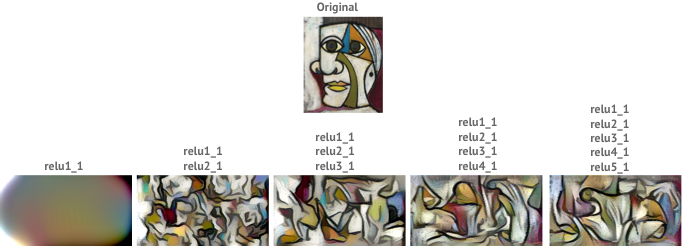

# Optimizing loss function and styling the image:
* Using a pre-trained neural network such as VGG-19, an input image (i.e. an image which provides the content), a style image (a painting with strong style elements) and a random image (output image), one could minimize the losses in the network such that the style loss (loss between the output image style and style of ‘style image’), content loss (loss between the content image and the output image) and the total variation loss (which ensured pixel wise smoothness) were at a minimum. In such cases, the output image generated from such a network, resembled the input image and had the stylist attributes of the style image.

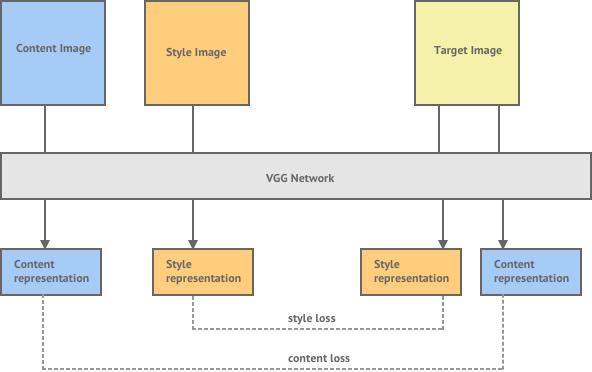

* The total loss can be written as:

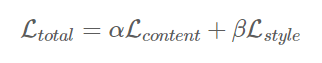

* We minmize our total loss by using an optimizer.

In [12]:
# Defining alpha and beta for the total loss:

alpha = 0.05
beta = 5.0
total_variation_weight = 1.0

In [13]:
# Creating the dictionary containing all the layers in he model:

layers = dict([(layer.name, layer.output) for layer in model.layers])

In [14]:
# Defining the loss variable:

loss = backend.variable(0.)

In [15]:
# Defining the content loss:

def content_loss(content, combination):
    return backend.sum(backend.square(content-combination))

In [16]:
# Extracting the layer features for the content image:

layer_features = layers['block2_conv2']
content_image_features = layer_features[0,:,:,:]
combination_features = layer_features[2,:,:,:]

# Calculating the content loss:
loss += alpha * content_loss(content_image_features,combination_features)

In [17]:
# Defining a function to form the gram matrix:

def gram_matrix(x):
    features  =backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [18]:
# Defining the style loss:

def style_loss(style,combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    st = backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
    return st

In [19]:
# Creating a dictionary to store the layers which will be used to form the styling image:

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

In [20]:
# Extracting the layer features and the styling loss:

for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1,:,:,:]
    combination_features = layer_features[2,:,:,:]
    sl = style_loss(style_features,combination_features)
    loss += (beta/len(feature_layers))*sl

In [21]:
# Defining the total loss:

def total_variation_loss(x):
    a=backend.square(x[:,:height-1,:width-1,:]-x[:,1:,:width-1,:])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))
loss += total_variation_weight * total_variation_loss(combination_image)

In [22]:
# Calculating the gradients:

grads = backend.gradients(loss, combination_image)

In [23]:
# Forming the output array and applying the function:

outputs=[loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = backend.function([combination_image], outputs)

In [24]:
# Defining a function to get the loss and gradient values:

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

In [25]:
# Defining the Evaluator class:

class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None
    
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [26]:
# Creating an instance of the class Evaluator:

evaluator = Evaluator()

In [27]:
# Defining the array x and number of iterations:

x = np.random.uniform(0,255,(1,height,width,3))-128.0

iterations = 10

In [28]:
# Generating the image:

import time
for i in range(iterations):
    print('Start of iteration', i + 1)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                           fprime = evaluator.grads, maxfun = 20)
    print(min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i + 1, end_time - start_time))

Start of iteration 1
136981545000.0
Iteration 1 completed in 8s
Start of iteration 2
52732846000.0
Iteration 2 completed in 4s
Start of iteration 3
43126948000.0
Iteration 3 completed in 4s
Start of iteration 4
40680186000.0
Iteration 4 completed in 4s
Start of iteration 5
39652532000.0
Iteration 5 completed in 4s
Start of iteration 6
39105155000.0
Iteration 6 completed in 4s
Start of iteration 7
38810665000.0
Iteration 7 completed in 4s
Start of iteration 8
38638174000.0
Iteration 8 completed in 4s
Start of iteration 9
38524080000.0
Iteration 9 completed in 4s
Start of iteration 10
38448017000.0
Iteration 10 completed in 4s


In [29]:
# Reshaping the generated image in a representable form:

x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

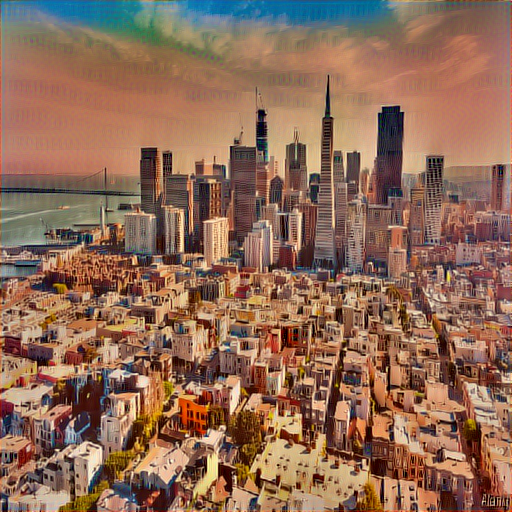

In [30]:
# Printing the generated Image:

Image.fromarray(x)

* I strongly recommend everyone to check the original paper by **Gatys**. All of the work shown above is a demonstration from his paper only.